<a href="https://colab.research.google.com/github/subhajitphy/NUS_Projects/blob/main/scaled_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

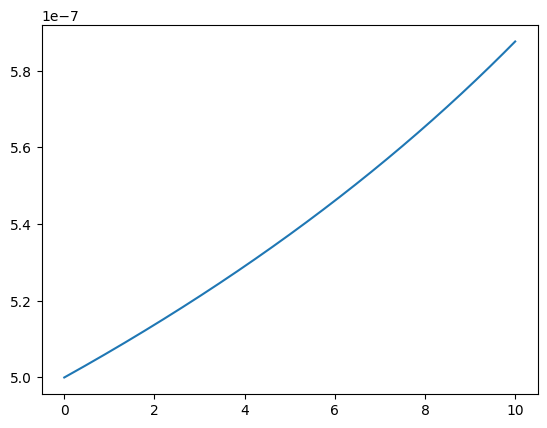

In [1]:
"""
Unified ANN↔PINN trainer for continuous GW ω(t) with StandardScaler support.

Key points
- Input time t and output ω are optionally standardized: (x - μ)/σ using sklearn's StandardScaler.
- Physics loss is applied entirely in *scaled* space:
      dω_s/dt_s   ≈   (σ_t / σ_ω) * f_rhs( ω_phys, ... )
  where ω_phys = ω_s * σ_ω + μ_ω
- Switch modes:
    --mode data   : pure data-fitting (ANN) in scaled space
    --mode pinn   : PINN (physics + data + IC) in scaled space
- Toggle scaling via --scale {standard, none}

Author: Subhajit
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from astropy.constants import GM_sun, c, pc
#from torchdiffeq import odeint

# Constants
GM_sun, c, pc = GM_sun.value, c.value, pc.value
dsun, tsun = GM_sun/(c**2), GM_sun/(c**3)
yr = 365.25 * 24 * 3600
tsun, yr = torch.tensor(tsun), torch.tensor(yr)

def f_rhs(omg,m_chirp,eta,chi_A,chi_S):
  m_total=m_chirp/eta**(3/5)
  nu=1
  delta=torch.sqrt(1-4*eta)
  tN_omg = tsun * m_chirp * omg  #post-Newtonian relation
  tm_omg = tsun * m_total * omg  #post-Newtonian relation
  Q_15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*torch.pi)
  return ((96/5) * omg**2 * tN_omg**(5/3) * (1 + (-743/336 - (11/4)*eta) * tm_omg**(2/3) * nu
          + Q_15 * tm_omg * nu**(3/2) + (34103/18144 + (13661/2016)*eta
          + (59/18)*eta**2) * tm_omg**(4/3) * nu**2))

num_points = 10000
t_span = torch.linspace(0, 10*yr, num_points, dtype=torch.float64)

omg_a, m_c, eta, nu, chi_A, chi_S = map(
    lambda x: torch.tensor(x, dtype=torch.float64),
    [5e-7, 1e9, 1/4, 1.0, 0.4, 0.5]
)

def get_omg(t,t_a,omg_a,m_c,eta,nu,chi_A,chi_S):
    m=m_c/eta**(3/5)
    tN_ = m_c*omg_a*tsun
    tm_ = m*omg_a*tsun
    tmta_ = t-t_a
    delta=torch.sqrt(1-4*eta)
    tau = 1-256/5*omg_a*tN_**(5/3)*tmta_
    Q15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*torch.pi)
    ww=(omg_a*(((371/128*eta**2+56975/16128*eta+1855099/903168)/tau**(7/8)+(-3058673/
    1354752-617/192*eta**2-5429/1344*eta)/tau**(11/8)+(-605/192*eta**2-40865/8064*eta-\
    2760245/1354752)/tau**(13/8)+(1331/384*eta**2+89903/16128*eta+6072539/2709504)/
    tau**(19/8))*tm_**(4/3)*nu**2+(3/5/tau**(11/8)*Q15-3/5/tau**(3/4)*Q15)*tm_*nu**(3/2)+
    ((11/8*eta+743/672)/tau**(5/8)+(-11/8*eta-743/672)/tau**(11/8))*tm_**(2/3)*nu+1/
    tau**(3/8)))
    return ww


omg_arr=get_omg(t_span,0,omg_a,m_c,eta,nu,chi_A,chi_S)

plt.plot(t_span/yr,omg_arr)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
X_scaler = StandardScaler()
y_scaler = StandardScaler()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
num_points = 10000

t_phys = torch.linspace(0, 10*yr, 1000, dtype=torch.float64, device=device).reshape(-1,1)
w_phys = get_omg(t_phys,0, omg_a, m_c, eta, nu, chi_A, chi_S).reshape(-1,1)

In [7]:
t_scaler = StandardScaler().fit(t_phys.cpu().numpy())
w_scaler = StandardScaler().fit(w_phys.cpu().numpy())
t_scaled = torch.from_numpy(t_scaler.transform(t_phys.cpu().numpy())).to(device).double()
w_scaled_obs = torch.from_numpy(w_scaler.transform(w_phys.cpu().numpy())).to(device).double()
t_sigma = torch.tensor(t_scaler.scale_.reshape(1,1), dtype=torch.float64, device=device)
w_mu = torch.tensor(w_scaler.mean_.reshape(1,1), dtype=torch.float64, device=device)
w_sigma = torch.tensor(w_scaler.scale_.reshape(1,1), dtype=torch.float64, device=device)

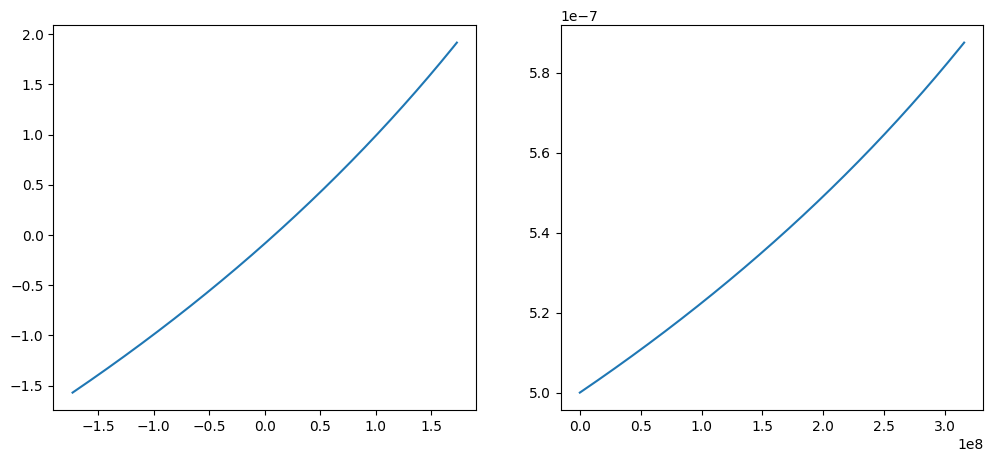

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(t_scaled,w_scaled_obs)
plt.subplot(122)
plt.plot(t_phys,w_phys)

In [9]:
class NN(nn.Module):
    def __init__(self, width=64, depth=4):
        super().__init__()
        layers = [nn.Linear(1, width), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

In [10]:
def model_derivative_scaled(model, t_scaled):
    t_scaled_req = t_scaled.clone().detach().requires_grad_(True)
    w_scaled_pred = model(t_scaled_req)
    (dw_scaled_dt_scaled,) = torch.autograd.grad(
        outputs=w_scaled_pred, inputs=t_scaled_req,
        grad_outputs=torch.ones_like(w_scaled_pred),
        create_graph=True, retain_graph=True
    )
    return w_scaled_pred, dw_scaled_dt_scaled

In [11]:
def rhs_scaled(w_scaled_pred, m_c, eta, chi_A, chi_S, w_mu, w_sigma, t_sigma):
    w_phys = w_scaled_pred * w_sigma + w_mu
    rhs_phys = f_rhs(w_phys, m_c, eta, chi_A, chi_S)
    return (t_sigma / w_sigma) * rhs_phys

In [12]:
model = NN().to(device).double()
opt = optim.Adam(model.parameters(), lr=2e-3)
mse = nn.MSELoss()

In [13]:
epochs=2000; w_phy=1.0; w_data=0; w_ic=1

In [14]:
for epoch in range(1, epochs+1):
      opt.zero_grad()
      w_scaled_pred, dw_scaled_dt_scaled = model_derivative_scaled(model, t_scaled)
      rhs_s = rhs_scaled(w_scaled_pred, m_c, eta, chi_A, chi_S, w_mu, w_sigma, t_sigma)
      loss_phy = mse(dw_scaled_dt_scaled, rhs_s)
      loss_data = mse(w_scaled_pred, w_scaled_obs)
      loss_ic = mse(model(t_scaled[:1]), w_scaled_obs[:1])
      loss = w_phy*loss_phy + w_data*loss_data + w_ic*loss_ic
      loss.backward()
      opt.step()

      if epoch % 200 == 0:
          print(f"[{epoch}] total={loss.item():.3e}, phy={loss_phy.item():.3e}, data={loss_data.item():.3e}, ic={loss_ic.item():.3e}")

[200] total=6.516e-04, phy=6.469e-04, data=5.746e-04, ic=4.688e-06
[400] total=1.065e-04, phy=1.064e-04, data=9.482e-05, ic=1.818e-07
[600] total=3.962e-05, phy=3.959e-05, data=6.303e-05, ic=2.968e-08
[800] total=1.992e-05, phy=1.991e-05, data=5.410e-05, ic=7.985e-09
[1000] total=1.150e-05, phy=1.149e-05, data=5.042e-05, ic=3.015e-09
[1200] total=9.483e-04, phy=1.575e-04, data=2.846e-04, ic=7.908e-04
[1400] total=8.499e-06, phy=8.497e-06, data=4.942e-05, ic=2.216e-09
[1600] total=5.601e-06, phy=5.600e-06, data=4.780e-05, ic=9.269e-10
[1800] total=1.608e-02, phy=1.753e-03, data=1.061e-02, ic=1.433e-02
[2000] total=8.228e-06, phy=8.225e-06, data=4.992e-05, ic=2.787e-09


In [15]:
with torch.no_grad():
  w_scaled_pred = model(t_scaled)

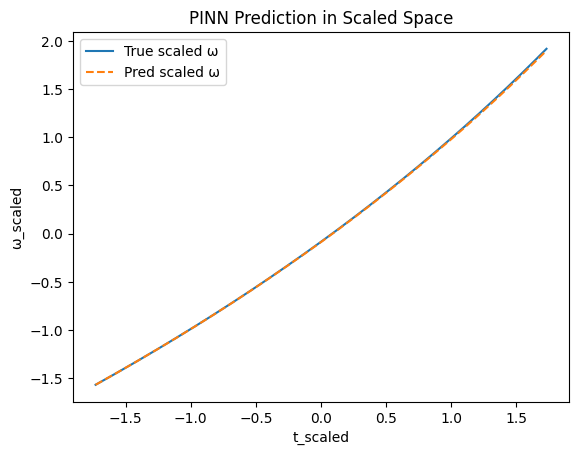

In [16]:
plt.figure()
plt.plot(t_scaled.cpu().numpy(), w_scaled_obs.cpu().numpy(), label="True scaled ω")
plt.plot(t_scaled.cpu().numpy(), w_scaled_pred.cpu().numpy(), label="Pred scaled ω", linestyle="--")
plt.xlabel("t_scaled")
plt.ylabel("ω_scaled")
plt.legend()
plt.title("PINN Prediction in Scaled Space")
plt.show()

In [17]:
def predict_physical(model, t_phys, t_scaler, w_scaler, device):
    """
    Given physical t (torch tensor), return predicted ω in physical units.
    """
    # scale t
    t_scaled_np = t_scaler.transform(t_phys.cpu().numpy())
    t_scaled = torch.from_numpy(t_scaled_np).to(device).double()

    # predict scaled ω
    with torch.no_grad():
        w_scaled_pred = model(t_scaled)

    # inverse-transform to physical ω
    w_phys_pred_np = w_scaler.inverse_transform(w_scaled_pred.cpu().numpy())
    return torch.from_numpy(w_phys_pred_np).to(device).double()

In [18]:
w_phys_pred=predict_physical(model, t_phys, t_scaler, w_scaler, device)

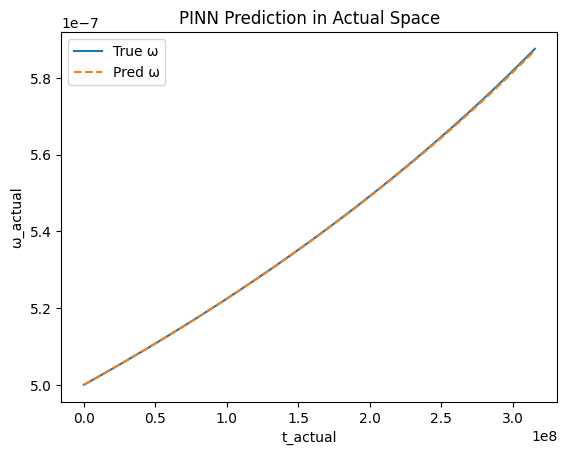

In [19]:
plt.figure()
plt.plot(t_phys.cpu().numpy(), w_phys.cpu().numpy(), label="True ω")
plt.plot(t_phys.cpu().numpy(), w_phys_pred.cpu().numpy(), label="Pred ω", linestyle="--")
plt.xlabel("t_actual")
plt.ylabel("ω_actual")
plt.legend()
plt.title("PINN Prediction in Actual Space")
plt.show()